In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CSV_DATA = Path().cwd().parent.parent / "data/1_transformed"

In [2]:
df = pd.read_csv(CSV_DATA/'summary/ride_summary.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['start_time'] = pd.to_timedelta(df['start_time'])
df['end_time'] = pd.to_timedelta(df['end_time'])

In [3]:
power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h', 'best_power_2h', 'best_power_3h',
                    'best_power_4h']

In [ ]:
import re
def plot_summary_power_curves(df_summary:pd.DataFrame, ride_id_subset:list[str]=None, figsize:tuple=(12,4), 
                              logscale_base:int=10, title:str='Best Ride Efforts Power Curve', show_best_cyclist_curve:bool=True):
    # Subset the df_summary columns and filter for the relevant ride_ids
    cols_of_interest = ['ride_id', 'start_date','total_distance_mi','total_ascent_ft','avg_power']
    power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h', 'best_power_2h', 'best_power_3h',
                    'best_power_4h']
    cols_of_interest += power_cols
    if ride_id_subset is None: ride_id_subset = df['ride_id'].values # if not specified, all rides will be plotted
    df_rides = df_summary.copy().loc[df_summary['ride_id'].isin(ride_id_subset), cols_of_interest]
    n_rides = df_rides.shape[0]

    # Create a mapping from power column names back to axis labels and values
    pattern = r'best_power_([\d]+)([smh])'
    seconds_map = {'s':1, 'm':60, 'h':60*60}
    power_col_map = dict()
    for col in power_cols:
        matched = re.match(pattern, col)
        if matched is not None:
            value, unit = matched.groups()
            power_col_map[col] = {'label':value+unit,'duration':int(value)*seconds_map[unit]}

    ########################################################################
    # Create the Figure
    fig, ax = plt.subplots(1,1, figsize=figsize)
    # For each ride, plot its power curve

    for _, row in df_rides.iterrows():
        ride_id = row['ride_id']
        data = [{'duration':power_col_map[col]['duration'], 'best_power':row[col]} for col in power_cols]
        df_pwr = pd.DataFrame(data)
        _ = sns.lineplot(df_pwr, x='duration', y='best_power', ax=ax, alpha=0.5, legend=False)
        _ = sns.scatterplot(df_pwr, x='duration', y='best_power', ax=ax, alpha=0.5, legend=False)

    if show_best_cyclist_curve:
        # top 1% of cyclists, ref: https://www.cyclinganalytics.com/blog/2018/06/how-does-your-cycling-power-output-compare
        top_cyclist_powers = {'best_power_4s':1650, 'best_power_5s':1500,'best_power_10s':1375, 'best_power_20s':1200, 'best_power_30s':1000, 'best_power_1m':775,
                            'best_power_2m':600, 'best_power_3m':560, 'best_power_4m':535, 'best_power_5m':510,
                            'best_power_6m':500, 'best_power_10m':490, 'best_power_20m':460, 'best_power_30m':420,
                            'best_power_40m':375, 'best_power_1h':360}
        data = [{'duration':power_col_map[col]['duration'], 'best_power':top_cyclist_powers[col]} for col in top_cyclist_powers.keys()]
        df_pwr_top = pd.DataFrame(data)
        _ = ax.plot(df_pwr_top['duration'],df_pwr_top['best_power'], alpha=0.8, c='red', linestyle='--')
        _ = ax.scatter(df_pwr_top['duration'],df_pwr_top['best_power'],label='Top 99% Cyclist', alpha=0.8, marker='d', c='red', linewidths=2)
        _ = plt.legend(loc='best')
    

    ########################################################################
    # Set the axes up for plotting
    def forward(x):
        return np.log10(x) / np.log10(logscale_base)

    def inverse(x):
        return logscale_base**x
    
    if logscale_base==10:
        _ = ax.set_xscale('log')
    else:
        _ = ax.set_xscale('function', functions=(forward,inverse))
    _ = plt.xticks(ticks=[col['duration'] for col in power_col_map.values()], 
                   labels=[col['label'] for col in power_col_map.values()], rotation=45)
    _ = plt.grid()
    _ = ax.set_axisbelow(True)
    _ = plt.xlabel('Effort Time Duration', fontsize=14)
    _ = plt.ylabel('Maximum Effort Power (W)', fontsize=14)
    _ = plt.title(title, fontsize=18)

In [5]:
#plot_summary_power_curves(df_summary=df)

In [6]:
df.loc[:,['ride_id'] + power_cols].describe()

,best_power_4s,best_power_5s,best_power_10s,best_power_20s,best_power_30s,best_power_1m,best_power_2m,best_power_3m,best_power_4m,best_power_5m,best_power_6m,best_power_10m,best_power_20m,best_power_30m,best_power_40m,best_power_1h,best_power_2h,best_power_3h,best_power_4h
count,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.880000e+02,3.880000e+02,3.870000e+02,3.870000e+02,3.870000e+02,3.870000e+02,3.860000e+02,3.840000e+02,3.540000e+02,3.070000e+02,256.000000,144.000000,33.000000,17.000000,9.000000
mean,1.289898e+06,1.244042e+06,8.325974e+05,4.309838e+05,2.955207e+05,1.479514e+05,5.465384e+04,3.648888e+04,2.740823e+04,2.195519e+04,1.836587e+04,1.112455e+04,6.079701e+03,4.697421e+03,4228.176747,4981.079785,98.561643,91.656468,71.123400
std,1.807175e+07,1.743071e+07,1.184305e+07,6.114182e+06,4.091819e+06,2.046021e+06,9.493931e+05,6.329270e+05,4.746945e+05,3.797544e+05,3.168705e+05,1.906164e+05,9.926088e+04,7.105464e+04,58353.797514,51849.719449,25.493544,24.131256,14.176925
min,2.673270e+01,2.633882e+01,2.289366e+01,1.618540e+01,1.178595e+02,7.904596e+01,5.879504e+01,4.403440e+01,4.202178e+01,3.948658e+01,3.598485e+01,2.396082e+01,2.777508e+01,2.388482e+01,21.372630,35.259019,62.957003,58.440497,50.912622
25%,3.961385e+02,3.890909e+02,3.722069e+02,3.192267e+02,2.847698e+02,2.240995e+02,1.895179e+02,1.697844e+02,1.586981e+02,1.505454e+02,1.428214e+02,1.292631e+02,1.077397e+02,9.550460e+01,89.886686,81.756631,78.886242,74.049572,64.309176
50%,5.144553e+02,5.104387e+02,4.789934e+02,4.023300e+02,3.456376e+02,2.719892e+02,2.173253e+02,1.946047e+02,1.820773e+02,1.732502e+02,1.680334e+02,1.490149e+02,1.291916e+02,1.199189e+02,111.766579,105.361736,98.603063,88.109897,69.703654
75%,7.475562e+02,7.344971e+02,6.709884e+02,5.410244e+02,4.702781e+02,3.316215e+02,2.492310e+02,2.193058e+02,2.044878e+02,1.933540e+02,1.870020e+02,1.673968e+02,1.481948e+02,1.381433e+02,129.658153,124.791209,106.585810,101.671736,77.736997
max,3.208217e+08,3.094375e+08,2.149079e+08,1.115012e+08,7.433416e+07,3.716710e+07,1.858360e+07,1.238909e+07,9.291836e+06,7.433471e+06,6.194567e+06,3.716789e+06,1.858430e+06,1.238978e+06,929264.497279,619550.802787,162.896232,139.558873,93.835000


# Finding Rides which Violate Data Quality Limits

At this point, I'm going to install Great Expectations to manage the data validation. This is done with `pip install great_expectations`. For `great_expectations-1.4.3` the install reverted `pandas` from 2.2.3 --> 2.1.4

In [7]:
import great_expectations as gx
import great_expectations.expectations as gxe
# ref: https://docs.greatexpectations.io/docs/core/introduction/
# context stored in memory (ref: https://docs.greatexpectations.io/docs/core/set_up_a_gx_environment/create_a_data_context/)
context = gx.get_context(mode='ephemeral') 
print(type(context).__name__)

EphemeralDataContext


In [8]:
data_source_name = 'ride_summary_data'
data_source = context.data_sources.add_pandas(name=data_source_name)
print(type(data_source).__name__)
# ref: https://docs.greatexpectations.io/docs/core/connect_to_data/dataframes

PandasDatasource


In [9]:
data_asset_name = 'summary_dataframe'
data_asset = data_source.add_dataframe_asset(name=data_asset_name)

In [10]:
batch_definition_name = 'whole_summary_dataframe'
batch_definition = data_asset.add_batch_definition_whole_dataframe(
    batch_definition_name
)

In [11]:
batch_parameters = {"dataframe": df}

In [12]:
# Get the dataframe as a Batch
batch = batch_definition.get_batch(batch_parameters=batch_parameters)

In [ ]:
power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h']

# top 1% of cyclists, ref: https://www.cyclinganalytics.com/blog/2018/06/how-does-your-cycling-power-output-compare
top_cyclist_powers = {'best_power_4s':1650, 'best_power_5s':1500,'best_power_10s':1375, 'best_power_20s':1200, 'best_power_30s':1000, 'best_power_1m':775,
                    'best_power_2m':600, 'best_power_3m':560, 'best_power_4m':535, 'best_power_5m':510,
                    'best_power_6m':500, 'best_power_10m':490, 'best_power_20m':460, 'best_power_30m':420,
                    'best_power_40m':375, 'best_power_1h':360}
# violation indices
violations = dict()
expectations = dict()
# Create an Expectation to test
for col in power_cols:
    expectations[col] = gxe.ExpectColumnValuesToBeBetween(column=col, max_value=top_cyclist_powers[col], min_value=0)
    validation_results = batch.validate(expectations[col], **{"result_format": "COMPLETE"})
    violations[col] = validation_results['result']['unexpected_index_list']




Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 480.31it/s]


In [14]:
# # expectation = gx.expectations.ExpectColumnValuesToBeBetween(
# #     column="best_power_4s", max_value=1500, min_value=0
# # )
# # Test the Expectation
# validation_results = batch.validate(expectation)
# #print(validation_results)
# violation_indices = validation_results['result']['partial_unexpected_index_list']

In [15]:
from functools import reduce
violations_indices = list(set(reduce(lambda x,y: x+y,violations.values(), [])))
violations_indices.sort()
print(len(violations_indices))

46


In [16]:
print(violations_indices)

[26, 27, 39, 47, 60, 71, 72, 88, 101, 103, 104, 107, 108, 111, 112, 115, 116, 118, 119, 120, 122, 126, 130, 175, 181, 192, 223, 230, 232, 233, 234, 237, 238, 239, 240, 241, 245, 254, 259, 276, 283, 306, 327, 349, 358, 389]


In [20]:
df_violations = df.loc[df.index.isin(violations_indices),:]
df_no_violations = df.loc[~df.index.isin(violations_indices),:]

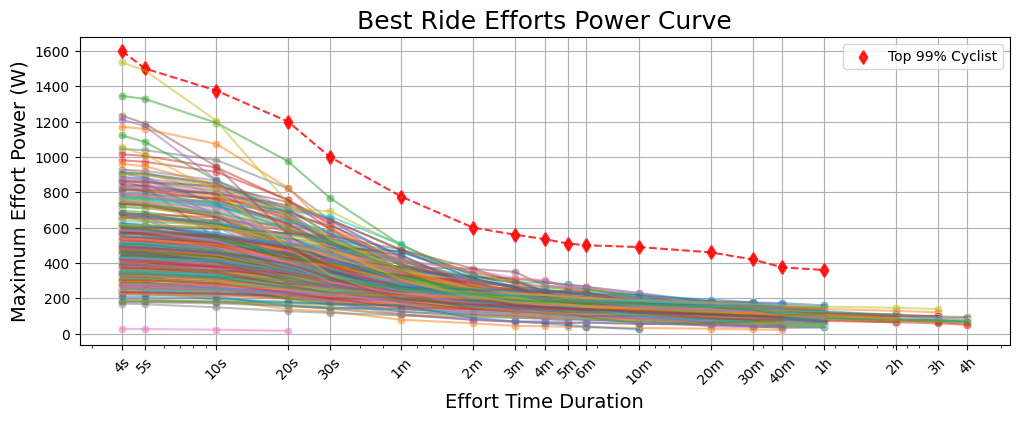

In [18]:
plot_summary_power_curves(df_summary=df_no_violations)

In [19]:
df_no_violations.loc[:, power_cols].describe()

,best_power_4s,best_power_5s,best_power_10s,best_power_20s,best_power_30s,best_power_1m,best_power_2m,best_power_3m,best_power_4m,best_power_5m,best_power_6m,best_power_10m,best_power_20m,best_power_30m,best_power_40m,best_power_1h
count,343.000000,343.000000,343.000000,343.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,341.000000,339.000000,312.000000,268.000000,220.000000,118.000000
mean,516.903616,511.940713,477.231610,402.237688,348.211261,268.104901,212.476363,189.081345,175.554646,166.453463,160.001161,142.512926,122.263402,112.445368,105.096636,97.810719
std,211.131695,207.141405,182.185294,140.816990,111.899961,72.436291,47.821660,40.850432,37.454702,35.547148,33.971476,30.881253,28.334662,28.374768,27.576267,26.105535
min,26.732701,26.338816,22.893665,16.185404,117.859536,79.045958,58.795042,44.034404,42.021780,39.486576,35.984848,23.960822,27.775078,23.884820,21.372630,35.259019
25%,369.898399,367.907661,347.375742,304.951268,272.732446,219.251801,185.548736,167.164924,155.476581,146.716920,140.587107,125.774583,105.546072,93.003309,87.087725,80.766010
50%,478.527601,475.209001,451.170666,381.099089,332.814867,259.669628,211.122435,190.000902,177.035930,169.354216,164.039184,145.695388,126.815170,116.104295,107.896057,101.890378
75%,602.851838,599.319108,557.461794,483.775721,401.480146,308.280312,236.583802,211.188559,195.267260,185.506925,178.478202,161.799621,141.259941,132.603069,124.527720,114.211199
max,1534.588472,1489.411967,1204.216725,975.043473,768.391517,505.080407,368.238988,349.406975,303.259288,279.396944,268.309409,230.578543,191.886155,179.375974,172.484059,160.376471


In [27]:
df_violations['year'] = df_violations['start_date'].dt.year
df_violations[['year','ride_id']].groupby('year').count().rename(columns={'ride_id':'violation_count'})

/tmp/ipykernel_5854/3244180785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_violations['year'] = df_violations['start_date'].dt.year


,violation_count
year,
2020,23
2021,14
2022,3
2023,2
2024,3
2025,1


In [28]:
df_violations.tail(10)

,ride_id,start_date,start_time,end_time,biker_weight_lbs,bike_weight,bag_weight,avg_speed,avg_cruising_speed,total_ride_time_sec,total_moving_time_sec,total_distance_mi,total_ascent_ft,total_descent_ft,avg_heart_rate,avg_power,avg_cadence,avg_ambient_temp_F,best_power_4s,best_power_5s,best_power_10s,best_power_20s,best_power_30s,best_power_1m,best_power_2m,best_power_3m,best_power_4m,best_power_5m,best_power_6m,best_power_10m,best_power_20m,best_power_30m,best_power_40m,best_power_1h,best_power_2h,best_power_3h,best_power_4h,year
245,0x61786004,2021-10-26,0 days 20:07:32,0 days 20:51:41,215,25,0,14.057907,15.695180,2650.0,2144.0,9.642270,234.9196,286.1032,NaN,135.084001,NaN,NaN,1592.366130,1550.336164,1288.413315,807.669046,577.661082,367.477104,263.569652,237.704965,223.273704,187.870963,173.553851,162.054295,157.132716,149.774005,137.883753,NaN,NaN,NaN,NaN,2021
254,0x62239705,2022-03-05,0 days 16:59:49,0 days 21:56:23,215,25,0,10.780700,15.211012,17795.0,7550.0,34.169235,497.3996,497.3996,NaN,116.416857,NaN,NaN,24438.454691,23184.322816,17062.367989,10812.833495,7837.869311,3976.445055,2053.214664,1415.776450,1085.487256,899.153010,774.970349,523.869855,338.809448,273.673139,239.609914,198.911592,121.673154,121.48341,NaN,2022
259,0x62531733,2022-04-10,0 days 17:43:15,0 days 23:16:32,215,25,0,9.700480,13.551721,19998.0,4766.0,19.278267,1041.3894,1086.0110,138.074923,101.552736,NaN,77.065670,8488.218700,8084.786938,6196.038365,3532.969849,2438.588265,1373.108300,720.539410,512.330902,395.692158,340.347609,296.266171,243.300455,186.030944,163.368801,146.988763,140.309571,NaN,NaN,NaN,2022
276,0x6307daf8,2022-08-25,0 days 20:26:32,0 days 21:33:21,220,25,0,13.390409,15.154354,4010.0,2983.0,12.929427,204.4063,217.2022,NaN,127.029892,NaN,NaN,1447.595689,1436.360124,1390.772698,1219.957822,909.547869,539.156036,347.893557,282.919779,249.657304,232.561994,220.664218,189.944171,159.656414,154.460614,148.617054,NaN,NaN,NaN,NaN,2022
283,0x63f28e19,2023-02-19,0 days 21:01:13,0 days 21:31:30,220,25,0,7.679256,12.806346,1818.0,855.0,3.623118,149.9417,77.7597,NaN,74.665820,NaN,NaN,3507.770021,3400.584889,2731.807915,1631.178250,1111.047531,580.687514,308.378895,221.098723,177.058528,158.076123,139.875929,135.036967,95.288219,NaN,NaN,NaN,NaN,NaN,NaN,2023
306,0x647fc3f0,2023-06-06,0 days 23:40:32,0 days 00:15:32,220,25,0,14.488376,14.973331,2101.0,1459.0,6.373484,131.2400,125.9904,137.498105,204.069811,NaN,80.616488,18909.573679,18224.429106,12873.894138,6720.537148,4484.015451,2281.734916,1230.644020,848.225407,663.728056,568.400435,503.133221,368.660927,239.987837,NaN,NaN,NaN,NaN,NaN,NaN,2023
327,0x6647e479,2024-05-17,0 days 23:12:57,0 days 00:55:30,220,25,0,14.820830,15.589168,6154.0,3493.0,15.286096,262.1519,262.1519,NaN,139.101988,NaN,NaN,4543.321497,4392.795645,3263.142945,1804.312061,1236.707453,669.233840,392.081268,303.596405,258.264313,236.014039,215.417160,200.659436,184.131321,163.012482,144.401665,140.700450,NaN,NaN,NaN,2024
349,0x66b21062,2024-08-06,0 days 12:00:34,0 days 12:49:09,210,25,0,15.952979,16.461781,2916.0,2645.0,12.253029,214.5774,214.2493,NaN,155.904960,NaN,NaN,2245.858108,2168.153348,1698.657628,1003.865536,709.041669,423.212059,282.873937,229.934502,214.967059,207.263301,195.167901,178.890006,172.298954,166.199085,163.496992,NaN,NaN,NaN,NaN,2024
358,0x66ce5861,2024-08-27,0 days 22:51:13,0 days 00:33:34,205,25,5,12.453687,14.248629,6142.0,5323.0,21.286734,339.9116,362.2224,NaN,98.198213,NaN,NaN,1640.788757,1533.159428,926.207543,465.636093,310.746466,213.239917,208.604391,194.604730,177.365567,164.031706,156.667287,152.671480,137.233988,124.361942,120.193238,96.771579,NaN,NaN,NaN,2024
389,0x681a7b31,2025-05-06,0 days 21:12:17,0 days 21:23:42,235,25,5,14.777524,18.911344,686.0,496.0,2.652898,144.3640,433.7482,130.479102,336.250752,33.108716,80.388235,18465.389390,17539.797437,13034.608244,7063.646177,4829.850446,2510.164249,1422.895438,1015.260056,786.668982,663.298890,578.907551,362.029977,NaN,NaN,NaN,NaN,NaN,NaN,NaN